In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import pandas as pd
import numpy as onp
import scipy.stats as scistats

In [2]:
df = pd.read_csv('data/cookies.dat', delimiter=' ')

In [3]:
df.head()

,chips,location
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


In [4]:
df.describe()

,chips,location
count,150.000000,150.000000
mean,9.153333,3.000000
std,3.829831,1.418951
min,1.000000,1.000000
25%,6.000000,2.000000
50%,9.000000,3.000000
75%,12.000000,4.000000
max,21.000000,5.000000


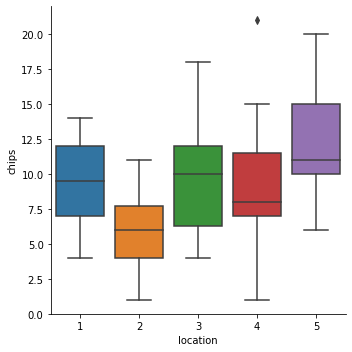

In [5]:
sns.catplot(x='location', y='chips', kind='box', data=df)

In [6]:
onp.random.seed(112)

In [7]:
prior_alpha = onp.random.exponential(.5, size=500)
prior_beta = onp.random.exponential(5, size=500)

In [8]:
prior_mu = prior_alpha/prior_beta
prior_sig = onp.sqrt(prior_alpha/prior_beta**2)

In [9]:
scistats.describe(prior_mu)

DescribeResult(nobs=500, minmax=(0.00016805033960631802, 78.72473752066911), mean=0.6972988971875471, variance=16.894316697393283, skewness=15.100454172185307, kurtosis=266.4060437893674)

In [10]:
scistats.describe(prior_sig)

DescribeResult(nobs=500, minmax=(0.005673106059013608, 142.64866794237915), mean=1.0030976354303764, variance=49.2319205140521, skewness=17.490072480650067, kurtosis=337.2955005934769)

In [11]:
prior_lambda = np.random.gamma(shape=1/prior_alpha, scale=prior_beta, size=500)

In [12]:
scistats.describe(prior_lambda)

DescribeResult(nobs=500, minmax=(0.00030801104680904683, 5962.272130998658), mean=71.6184893048787, variance=119383.65102864309, skewness=12.27799193502759, kurtosis=183.4283455876456)

In [13]:
prior_y = np.random.poisson(prior_lambda, size=500)

In [14]:
scistats.describe(prior_y)

DescribeResult(nobs=500, minmax=(0, 5922), mean=71.48, variance=118152.89939879757, skewness=12.235610811402553, kurtosis=182.31942808761102)

In [15]:
from jax import random, lax, nn
import jax.numpy as np

import numpyro
import numpyro.diagnostics as diag
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(3)
numpyro.enable_validation()

num_warmup, num_samples = 1000, 5000
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [16]:
chips = onp.empty((5, 30))
for i in range(1, 6):
    chips[i-1, :] = df.chips.values[df.location.values==i]

In [17]:
chips

array([[12., 12.,  6., 13., 12., 12.,  9., 10.,  7., 14., 12., 13.,  7.,
         6.,  9., 12.,  4., 11., 10.,  7.,  6.,  9.,  5., 10.,  8.,  9.,
         4., 12.,  8., 10.],
       [ 7.,  4.,  6.,  9.,  3.,  9.,  6.,  9.,  4.,  6., 10.,  9.,  5.,
         5.,  6.,  6.,  2.,  3.,  2.,  7.,  9.,  4., 11.,  1.,  4.,  8.,
         6.,  6.,  5.,  7.],
       [ 7.,  6.,  9.,  6., 15., 14.,  7., 11.,  7., 12., 11., 11., 12.,
         6., 12., 12.,  4., 11.,  6., 18.,  4.,  7.,  8., 12., 13., 15.,
         9.,  6.,  5., 11.],
       [ 8.,  9.,  7., 14.,  6., 10.,  1.,  5.,  7.,  7.,  8.,  9.,  6.,
         5., 10.,  7., 12., 10., 12., 15.,  8.,  7., 21., 14., 12.,  6.,
         7.,  5.,  8., 12.],
       [15., 10., 12., 10.,  6.,  8., 10., 11., 11., 16., 11., 13.,  6.,
        11., 20.,  6., 16., 13., 13., 11., 10., 16., 16.,  6., 16., 11.,
        11., 19., 11., 15.]])

In [18]:
def model_fn(chips):
    
    mu = numpyro.sample('mu', dist.Gamma(2, 10))
    sig = numpyro.sample('sig',  dist.Exponential(1))
    
    alpha = mu**2 / sig**2
    beta = mu / sig**2
    
    lambda_ = numpyro.sample('lam', dist.Gamma(alpha * np.ones(4), rate=beta * np.ones(4)))
    numpyro.sample('chips', dist.Poisson(lambda_), obs=chips)

In [19]:
kernel = NUTS(model_fn)
model = MCMC(kernel, num_warmup, num_samples, num_chains=3)
model.run(rng_key, collect_warmup=False, chips=df.chips.values)

TypeError: mul got incompatible shapes for broadcasting: (4,), (150,).

In [ ]:
model.print_summary()

In [ ]:
samples = model.get_samples()

In [ ]:
for var, samp in samples.items():
    plt.figure()
    plt.plot(samp)
    plt.title(var)

## Model Checking

In [ ]:
pm_params = {key: val.mean() for key, val in samples.items()}

In [ ]:
pm_params

# Part B

In [30]:
df = sm.datasets.get_rdataset('Leinhardt', package='carData').data

/Users/benhammel/Documents/projects/bayesian-stats-classes/venv/lib/python3.6/site-packages/statsmodels/datasets/utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()


In [31]:
df.head()

,income,infant,region,oil
Australia,3426,26.7,Asia,no
Austria,3350,23.7,Europe,no
Belgium,3346,17.0,Europe,no
Canada,4751,16.8,Americas,no
Denmark,5029,13.5,Europe,no


In [34]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,income,infant,region,oil
0,3426,26.7,Asia,no
1,3350,23.7,Europe,no
2,3346,17.0,Europe,no
3,4751,16.8,Americas,no
4,5029,13.5,Europe,no


In [35]:
from jax import random
import jax.numpy as np  # We need the CUDA mirror of numpy (even if we're on a CPU)

import numpyro
import numpyro.diagnostics as diag
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(3)  # Run mcmc in parallel
numpyro.enable_validation()  # Let pyro alert me to potential problems

In [ ]:
def mod2_fn(log_income, log_infant, is_oil, region):
    
    
    a = numpyro.sample()
    b1 = numpyro.sample('b1', dist.Normal(0, 1e6))
    b2 = numpyro.sample('b2', dist.Normal(0, 1e6))
    b3 = numpyro.sample('b3', dist.Normal(0, 1e6))

    std2 = numpyro.sample('std2', dist.InverseGamma(2.5, 2.5 * 10))
    std = np.sqrt(std2)

    mu = b1 + b2*log_income + b3*is_oil
    y = numpyro.sample('y', dist.Normal(mu, std), obs=log_infant)